<a href="https://colab.research.google.com/github/kmgr10/energy/blob/master/Energy_SARIMAX_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import urllib
from scipy.ndimage.interpolation import shift

In [0]:
# Load data and rename columns
link = "https://github.com/chiaracecilia/forecasting_competition/raw/master/load_weather_dataset.xlsx"
urllib.request.urlretrieve(link, "load_weather_dataset_recent.xlsx")
data = pd.read_excel('load_weather_dataset_recent.xlsx')

# If loading directly from gdrive:
#data = pd.read_excel('drive/My Drive/load_weather_dataset.xlsx')

data.columns=['Date','Temp_min','Temp_mean','Temp_max','Load','London_min','London_mean','London_max',
              'Bristol_min','Bristol_mean','Bristol_max','Leeds_min','Leeds_mean','Leeds_max','Lockdown_index']

data['Date'] = pd.to_datetime(data['Date'])

# Remove stuff that isn't within 1 day of the 'as of' date
# For example, as of 12 Jun, we have data up to 11 Jun and forecasts for 13 Jun - we want to predict load for 13 Jun
# So remove anything past 13 June - it seems the data source is inconsistent with NaN beyond that

today_date = dt.datetime(2020,6,12)
fcast_date = dt.datetime(2020,6,13)
yday_date = dt.datetime(2020,6,11)

data = data[data['Date']<=fcast_date]

In [0]:
# Add Bank holiday flags, as energy demand is lower on bank holiday days
# Note: have added the following '2020-04-20','2020-04-21','2020-04-22' (these are not bank holidays but load looks really low)
bh_ls = ['2017-01-01', '2017-04-14','2017-04-17', '2017-05-01', '2017-05-29','2017-08-28', '2017-12-25', '2017-12-26',
         '2018-01-01', '2018-03-30','2018-04-02', '2018-05-07', '2018-05-28', '2018-08-27', '2018-12-25', '2018-12-26',
         '2019-01-01', '2019-04-19','2019-04-22', '2019-05-06', '2019-05-27', '2019-08-26' , '2019-12-25', '2019-12-26',
         '2020-01-01', '2020-04-10','2020-04-13','2020-04-20','2020-04-21','2020-04-22', '2020-05-08', '2020-05-25']

bd_dt = [pd.to_datetime(x) for x in bh_ls]
data['Holiday'] = data['Date'].apply(lambda x: 1 if x in bd_dt else 0)
data_ar = data[['Date','Temp_mean','Load','Lockdown_index','Holiday']]

In [164]:
# Clean data
data['Lockdown_index'] = data['Lockdown_index'].apply(lambda x: 0 if np.isnan(x) else x)
data['Load'] = np.log(data_ar['Load'])
data_ar['Lockdown_index'] = data_ar['Lockdown_index'].apply(lambda x: 0 if np.isnan(x) else x)
data_ar['Log_load'] = np.log(data_ar['Load'])
data_ar = data_ar[:-2]
data_ar.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Temp_mean,Load,Lockdown_index,Holiday,Log_load
1253,2020-06-07,12.3,19706.750000,64.81,0,9.888716
1254,2020-06-08,12.7,21908.208330,70.37,0,9.994617
1255,2020-06-09,12.8,22262.312500,70.37,0,10.010651
1256,2020-06-10,12.9,23484.020833,70.37,0,10.064076
1257,2020-06-11,13.7,21509.041667,70.37,0,9.976229


In [0]:
# Scale the data
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

scaled_in= scaler_in.fit_transform(data_ar[['Temp_mean','Lockdown_index','Holiday']])
scaled_out = scaler_out.fit_transform(np.array(data_ar['Log_load']).reshape(-1,1))

X = scaled_in
y = scaled_out

n = 1200

# Train and test split
X_train, X_test = X[:n], X[n:]
y_train, y_test = y[:n], y[n:]

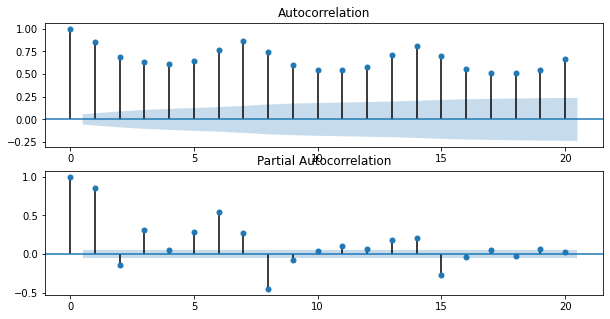

In [166]:
# Plot of autocorrelation to get an idea of p,q

fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_train, lags=20, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_train, lags=20, ax=ax[1])
plt.show()

In [0]:
# Define and fit SARIMAX

arima = (1,0,0) # AR(p) with p = 1 from PACF plot
seasonal = (1,0,0,7) # use m = 7 for seasonality from auto-correlation plot and p = 1 i.e. autoregressive part of seasonality based on last week's level

model_1 = SARIMAX(y_train,exog=X_train,order=arima,seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False).fit()

In [168]:
print(model_1.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1200
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                1740.626
Date:                           Fri, 12 Jun 2020   AIC                          -3469.252
Time:                                   18:56:47   BIC                          -3438.752
Sample:                                        0   HQIC                         -3457.759
                                          - 1200                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2399      0.018    -13.098      0.000      -0.276      -0.204
x2            -0.1514      0.056     -2.689

In [0]:
# Use model_1 to predict the test data

model_1_out_insample = model_1.predict()
model_1_out_outsample = model_1.predict(start=n,end=len(y)-1,exog=X_test,)

model_1_out = np.append(model_1_out_insample,model_1_out_outsample)
model_1_out = scaler_out.inverse_transform(model_1_out.reshape(-1,1))

# Map it back to the df for plotting
data_ar['model_1_forecast'] = model_1_out

In [170]:
# Show in-sample forecasts
cutoff = dt.datetime(2019,9,2)
plt_df = data_ar[data_ar['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['Log_load'],
                    mode='lines',
                    name='Log load'))
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['model_1_forecast'],
                    mode='lines',
                    name='SARIMAX'))
fig.show()

In [171]:
# Keep parameters, calibrate on full data set
model_2_out = SARIMAX(y,exog=X,order=arima,seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False).fit()
print(model_2_out.summary())
model_2_out_y = scaler_out.inverse_transform(model_2_out.predict().reshape(-1,1))

data_ar['model_2_forecast'] = model_2_out_y

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1258
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                1765.957
Date:                           Fri, 12 Jun 2020   AIC                          -3519.913
Time:                                   18:56:49   BIC                          -3489.128
Sample:                                        0   HQIC                         -3508.340
                                          - 1258                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2346      0.019    -12.313      0.000      -0.272      -0.197
x2            -0.1511      0.058     -2.599

In [172]:
# Show errors on the full set
cutoff = dt.datetime(2017,6,2)
plt_df = data_ar[data_ar['Date']>=cutoff]
fig = go.Figure()
fig.add_trace(go.Scatter(x=plt_df['Date'], y=plt_df['model_2_forecast']-plt_df['Log_load'],
                    mode='lines',
                    name='error'))
fig.show()

In [173]:
# What's the standard deviation of errors
np.std(plt_df['model_2_forecast']-plt_df['Log_load'])

0.04770011026277957

In [0]:
# Complete the missing data from the frame so we can predict
# i.e. compute temperature mean forecast, specify whether holiday, give lockdown_index

# variable today_date
today_hol = 0
today_lock = 70.37

# variable fcast_date
fcast_hol = 0
fcast_lock = 70.37

# Prior date (that's the last day all available info)
# variable yday_date

# Get temperature forecast for today
tmp_df_1 = data.loc[data['Date']==today_date]
temp_mean_1 = ((tmp_df_1['London_mean'] + tmp_df_1['Bristol_mean'] + tmp_df_1['Leeds_mean'])/3).squeeze()
# Get temperature forecast for tomorrow
tmp_df_2 = data.loc[data['Date']==fcast_date]
temp_mean_2 = ((tmp_df_2['London_mean'] + tmp_df_2['Bristol_mean'] + tmp_df_2['Leeds_mean'])/3).squeeze()

# Write back to df
data.loc[data['Date']==today_date,['Temp_mean']] = temp_mean_1
data.loc[data['Date']==fcast_date,['Temp_mean']] = temp_mean_2
data.loc[data['Date']==today_date,['Holiday']] = today_hol
data.loc[data['Date']==fcast_date,['Holiday']]=fcast_hol
data.loc[data['Date']==today_date,['Lockdown_index']] = today_lock
data.loc[data['Date']==fcast_date,['Lockdown_index']]=fcast_lock

In [0]:
# A function to predict and write-back using the SARIMAX model defined above
# Not changing the specification of the model, just calibrating to latest available data to generate today's load
# Then predict tomorrow's load

def fit_predict(frame, last_good_date, predict_date):
  '''frame is the input dataframe, last_good_date is the last date beyond which info needs to be predicted, 1 step at a time'''
  scaler_in = MinMaxScaler()
  scaler_out = MinMaxScaler()
  
  # You can only look at data up to today
  df = frame[frame['Date']<=last_good_date]

  # Scale the data
  scaled_in = scaler_in.fit_transform(df[['Temp_mean','Lockdown_index','Holiday']])
  scaled_out = scaler_out.fit_transform(np.array(df['Load']).reshape(-1,1))

  # Fit the model
  model = SARIMAX(scaled_out,exog=scaled_in,order=arima,seasonal_order=seasonal,enforce_stationarity=False,enforce_invertibility=False).fit()

  # Grab info for the date to be forecast
  predict_df = frame[frame['Date']==predict_date]
  x_exog = np.array(predict_df[['Temp_mean','Lockdown_index','Holiday']].squeeze())

  # Forecast it
  forecast_y = model.forecast(steps=1,exog=scaler_in.transform(x_exog.reshape(1,-1)))
  
  # Invert and return
  return scaler_out.inverse_transform(forecast_y.reshape(1,-1))[0][0]

In [0]:
# Generate and append today's Load
data.loc[data['Date']==today_date,['Load']] = fit_predict(data,yday_date,today_date)

In [0]:
# Generate and append tomorrow's forecast Load
data.loc[data['Date']==fcast_date,['Load']] = fit_predict(data,today_date,fcast_date)

In [178]:
print(f"Prediction is {np.round(data.loc[data['Date']==fcast_date]['Load'].squeeze(),2)}")

Prediction is 9.79
